# Import

In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, silhouette_score
from sklearn.preprocessing import LabelBinarizer
import random
from collections import Counter
from sklearn.utils import resample
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import seaborn as sn
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import copy
import cv2
from scipy import ndimage, spatial
import pickle
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import shutil
import os
from pathlib import Path
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
feature_description = {
    'jpg_bytes': tf.io.FixedLenFeature([], tf.string),
    'race': tf.io.FixedLenFeature([], tf.int64),
    'age': tf.io.FixedLenFeature([], tf.int64),
    'gender': tf.io.FixedLenFeature([], tf.int64),
    'subject_id': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.float32),
    'Consolidation': tf.io.FixedLenFeature([], tf.float32),
    'Edema': tf.io.FixedLenFeature([], tf.float32),
    'Enlarged Cardiomediastinum': tf.io.FixedLenFeature([], tf.float32),
    'Lung Opacity': tf.io.FixedLenFeature([], tf.float32),
    'Atelectasis': tf.io.FixedLenFeature([], tf.float32),
    'No Finding': tf.io.FixedLenFeature([], tf.float32),
    'Pleural Effusion': tf.io.FixedLenFeature([], tf.float32),
    'Pneumonia': tf.io.FixedLenFeature([], tf.float32),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.float32)
}

label_list = ['Pneumothorax', 'Pneumonia', 'Pleural Effusion', 'No Finding', 'Atelectasis', 'Lung Opacity','Enlarged Cardiomediastinum', 'Edema', 'Consolidation', 'Cardiomegaly']

In [4]:
train_filename = './data/new_mimic_train.tfrecords'
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
BUFFER_SIZE = 1000
BATCH_SIZE = 32
random_seed = 8042

In [5]:
data_train = tf.data.TFRecordDataset(train_filename)
data_val = pd.read_csv("D:\\Lab\\CheXpert\\new_val_with_attributes.csv")
data_test = pd.read_csv("D:\\Lab\\CheXpert\\new_test_with_attributes.csv")

# Preprocess

In [6]:
pixel = 5
num_noise = 12
def _parse(example):
    return tf.io.parse_single_example(example, feature_description)
def apply(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.image.decode_jpeg(example['jpg_bytes'], channels=3)
    labels = [tf.cast(0, tf.int32) if example['No Finding'] == 1 else tf.cast(1, tf.int32)]
    return img, labels

def fn1(img_arr):
    img_arr[:,0:3,:] = 128
    img_arr[0:3,:,:] = 128
    img_arr[:,-3:,:] = 128
    img_arr[-3:,:,:] = 128
        
    return img_arr

def fn2(img_arr):
    pred_mask = np.zeros((256, 256))
    img_arr[:,0:3,:] = 128
    img_arr[0:3,:,:] = 128
    img_arr[:,-3:,:] = 128
    img_arr[-3:,:,:] = 128
    pred_mask[:,0:3] = 1
    pred_mask[0:3,:] = 1
    pred_mask[:,-3:] = 1
    pred_mask[-3:,:] = 1
        
    return img_arr, pred_mask

def fn3(img_arr):
    pred_mask = np.zeros((256, 256))
    col = np.random.choice(img_arr.shape[1]-pixel, num_noise)
    row = np.random.choice(np.arange(img_arr.shape[0]-36, img_arr.shape[0]-pixel), num_noise)
    for r, c in zip(row,col):
        img_arr[r:r+pixel, c:c+pixel,:] = 128
        pred_mask[r:r+pixel, c:c+pixel] = 1
        
    return img_arr, pred_mask

def add_pixel(img, labels):
    img_arr = img.numpy()
    if labels.numpy() == 1:
        img_arr[:,0:3,:] = 128
        img_arr[0:3,:,:] = 128
        img_arr[:,-3:,:] = 128
        img_arr[-3:,:,:] = 128
    img_arr = tf.cast(img_arr, dtype=tf.uint8)
    return img_arr, labels

def wrapper_train(img, labels):
    img, label = tf.py_function(add_pixel, [img, labels], [tf.uint8, tf.int32])
    return img, label

In [16]:
def load_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def apply_img_val_test(filename, labels):
    path = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(path, channels=3)
    img = tf.image.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    img = tf.cast(img, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, labels

def apply_img_val_test_ig(filename, labels):
    path = tf.io.read_file(filename)
    orig_img = tf.image.decode_jpeg(path, channels=3)
    img_dim = orig_img.shape
    img = tf.image.resize(orig_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    img = tf.cast(img, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, labels, img_dim

def apply_img_val_test_ig_noise(filename, labels):
    path = tf.io.read_file(filename)
    # print(filename)
    img = cv2.imread(filename.numpy().decode(), cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
    img_arr = tf.cond(tf.math.equal(labels, 1), lambda: fn1(img), lambda: img)
    
    img = tf.cast(img, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, labels

def wrapper_val(filename, labels):
    img, label = tf.py_function(apply_img_val_test_ig_noise, [filename, labels], [tf.uint8, tf.int32])
    return img, label

In [17]:
img_path_val, img_path_test = data_val['Path'].to_numpy(), data_test['Path'].to_numpy()
target_label_val, target_label_test = [], []
for each in data_val['No Finding']:
    target_label_val.append(tf.cast(0, tf.int32) if each == 1 else tf.cast(1, tf.int32))
    
for each in data_test['No Finding']:
    target_label_test.append(tf.cast(0, tf.int32) if each == 1 else tf.cast(1, tf.int32))
    

In [18]:
data_test.head()

,Path,No Finding,Pleural Effusion,Gender,Age
0,D:/Lab/CheXpert/test/patient64745/study1/view1...,0,1,0,92
1,D:/Lab/CheXpert/test/patient64746/study1/view1...,0,1,1,53
2,D:/Lab/CheXpert/test/patient64747/study1/view1...,0,1,0,70
3,D:/Lab/CheXpert/test/patient64750/study1/view1...,1,0,0,40
4,D:/Lab/CheXpert/test/patient64756/study1/view1...,1,0,0,76


In [19]:
dataset_train = load_dataset(train_filename)
dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), target_label_val))
dataset_val = dataset_val.map(apply_img_val_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.batch(1, drop_remainder=True)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), target_label_test))
dataset_test = dataset_test.map(apply_img_val_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.shuffle(BUFFER_SIZE)
dataset_test = dataset_test.batch(1, drop_remainder=True)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [20]:
attribute_mimic = pd.read_csv("D:\\Lab\\CheXpert\\new_mimic_train_attributes.csv")
attribute_mimic.head()

,Study_id,Gender,Age
0,52912807,0,53
1,51959936,0,85
2,53279329,0,85
3,53691912,0,85
4,56124505,0,85


In [21]:
dict_age = {}
for idx, each in enumerate(attribute_mimic['Study_id']):
    dict_age[each] = [attribute_mimic['Gender'][idx], attribute_mimic['Age'][idx]]

# Model

In [22]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
input_img = Input(input_shape)
x = tf.keras.applications.densenet.preprocess_input(input_img)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor = x, pooling = 'avg')
x = base_model(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=input_img, outputs=predictions)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
____________________________________________

## Training

In [24]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=3),
                  ModelCheckpoint(filepath='./model/noise_baseline_v2.h5', monitor='val_binary_accuracy',save_best_only=True,mode='max'),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3)]
initial_learning_rate = 0.0001

In [25]:
opt = Adam(learning_rate=initial_learning_rate, epsilon=1e-8)
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

In [34]:
epochs = 50
history = model.fit(
    dataset_train,
    validation_data=dataset_val, 
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
)

In [35]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('./model/checkpoint_chexpert/acc.png', dpi=400, bbox_inches='tight')

# IG

In [57]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [58]:
for img, label in dataset_val:
    if label[0].numpy() == 1:
        img_target = img[0]
        break

In [59]:
m_steps= 500
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [60]:
def edited(baseline,  n=0.5):
    noise = np.random.normal(0, n, baseline.shape).astype(np.float32)
    return baseline + noise

In [68]:
def interpolated_image(image, alphas, n=0.00):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    
    image = tf.cast(image, tf.float32)
    input_x = tf.expand_dims(image, axis = 0)
    images = alphas_x * input_x
    noise = np.random.normal(0, n, images.shape).astype(np.float32)
    return images + noise

In [63]:
def compute_gradients(images, target):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = logits[:, target]
    return tape.gradient(probs, images)

In [65]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis = 0)
    return integrated_gradients

# calculate miou

In [40]:
def calculate_iou(pred_mask, gt_mask):
    """
    Calculate IoU score between two segmentation masks.

    Args:
        pred_mask (np.array): binary segmentation mask
        gt_mask (np.array): binary segmentation mask
    Returns:
        iou_score (np.float64)
    """
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    if np.sum(union) == 0:
        iou_score = np.nan
    else:
        iou_score = np.sum(intersection) / (np.sum(union))

    return iou_score

## IG noise

In [69]:
count = 0
biggest_iou = 0
model.load_weights('./model/noise_baseline.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_ig_noise\\'
if not os.path.exists(dr):
    os.mkdir(dr)
    
for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    
    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        if model.predict(tf.expand_dims(img, axis=0))[0][0] < 0.5:
            continue
        bs = np.zeros((256, 256, 3))
        
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        # temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()*3
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

In [70]:
count = 0
biggest_iou = 0
model.load_weights('./model/noise_baseline_v2.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_ig_noise_v2\\'
if not os.path.exists(dr):
    os.mkdir(dr)
    
for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    
    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        if model.predict(tf.expand_dims(img, axis=0))[0][0] < 0.5:
            continue
        bs = np.zeros((256, 256, 3))
        
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        # temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()*3
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

In [49]:
dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_proposed_attribute_noise\\'
count = 0
mean_mask_iou = []
for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict_test[patient_id][0]
    target_age = attr_dict_test[patient_id][1]
    
    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
            
        bg_dr = 'D:/Lab/x-ray/chexlocalize/all_result/test/'
        mask_dr = 'D:/Lab/x-ray/chexlocalize/all_bg/test/'
        gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        largest_iou = 0
        for raw_record in tqdm(data_train):

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            age = example.features.feature['age'].int64_list.value[0]
            gender = example.features.feature['gender'].int64_list.value[0]

            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age != target_age:
                continue
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    largest_iou = iou        
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        # temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()*3
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])
    
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)
        res_mask = np.where(temp_img <= 0, 0, 1)
        mask_iou = calculate_iou(res_mask, pred_mask)
        mean_mask_iou.append(mask_iou)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [61]:
hitrate = [1 if i > 0 else 0 for i in mean_mask_iou]
np.mean(hitrate)

1.0

In [50]:
np.mean(mean_mask_iou)

0.09531401867333293

In [53]:
dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_proposed_attribute_noise_v2\\'
model.load_weights('./model/noise_baseline_v2.h5')
count = 0
mean_mask_iou_2 = []
for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict_test[patient_id][0]
    target_age = attr_dict_test[patient_id][1]
    
    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
            
        bg_dr = 'D:/Lab/x-ray/chexlocalize/all_result/test/'
        mask_dr = 'D:/Lab/x-ray/chexlocalize/all_bg/test/'
        gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        # bs = np.zeros((256, 256, 3))
        largest_iou = 0
        for raw_record in tqdm(data_train):

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            age = example.features.feature['age'].int64_list.value[0]
            gender = example.features.feature['gender'].int64_list.value[0]

            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age != target_age:
                continue
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    largest_iou = iou        
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        # temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()*3
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])
    
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)
        res_mask = np.where(temp_img <= 0, 0, 1)
        mask_iou = calculate_iou(res_mask, pred_mask)
        mean_mask_iou_2.append(mask_iou)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

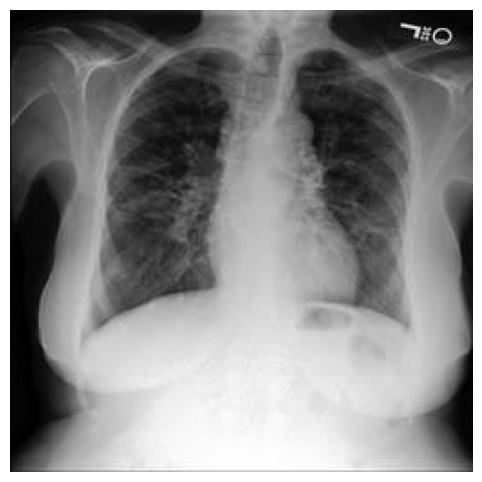

In [143]:
bg_dr = 'D:/Lab/x-ray/chexlocalize/all_result/val/'
mask_dr = 'D:/Lab/x-ray/chexlocalize/all_bg/val/'
fig, ax = plt.subplots(1, figsize = (12, 6))
for path_model in all_paths:
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['10']:
        continue
    model.load_weights(path_model)
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_hybrid_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
    
    for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        patient_id = target_path[0]
        target_path = '_'.join(target_path)
        if label == 0 or os.path.exists(dr + target_path + '_Pleural Effusion_map.pkl'):
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue

        # gt_mask = pickle.load(open('./segmentation_chexpert/val/' + target_path + '.pkl', "rb"))
        gt_mask = pickle.load(open('./segmentation_hybrid/val_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        if os.path.exists(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl'):
            bs = pickle.load(open(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl','rb'))
            
        else:
            
            largest_iou = 0
            for raw_record in tqdm(data_train):

                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                sid = example.features.feature['subject_id'].int64_list.value[0]
                img_id = example.features.feature['study_id'].int64_list.value[0]

                label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
                if label_test == 1:
                    continue
                bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)

                iou = calculate_iou(bs_mask, gt_mask)

                if iou > largest_iou:
                    img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                    y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                    if y_pred < 0.5:
                        # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        largest_mask = copy.deepcopy(bs_mask)
                        largest_mask = np.zeros((bs_mask.shape[0], bs_mask.shape[1], 3))
                        largest_mask[:,:,0]= bs_mask[:,:,0]
                        largest_mask[:,:,1]= bs_mask[:,:,0]
                        largest_mask[:,:,2]= bs_mask[:,:,0]
                        largest_img_bs = copy.deepcopy(img_bs)
                        largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        bs = np.where(largest_mask > 0, largest_img_bs, 0)
                        largest_iou = iou

            if not os.path.exists(bg_dr + patient_id):
                os.mkdir(bg_dr + patient_id)

            ax.imshow(largest_img_bs.numpy() , cmap='gray')
            ax.imshow(bs, alpha=0.5)
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/bg_hybrid_' + ep + '.png', dpi=400, bbox_inches='tight')


            ax.imshow(img.numpy() , cmap='gray')
            ax.imshow(gt_mask.numpy(), alpha=0.5)
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/img_with_hybrid.png', dpi=400, bbox_inches='tight')

            ax.imshow(largest_img_bs.numpy() , cmap='gray')
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/bg_img_' + ep + '.png', dpi=400, bbox_inches='tight')

            if not os.path.exists(mask_dr + patient_id):
                os.mkdir(mask_dr + patient_id)
            with open(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl','wb') as f:
                pickle.dump(bs, f)

            with open(mask_dr + patient_id + '/whole_hybrid_' + ep + '.pkl','wb') as f:
                pickle.dump(largest_img_bs.numpy(), f)

        # ig
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.numpy().astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        # temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()*3
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img.numpy()
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

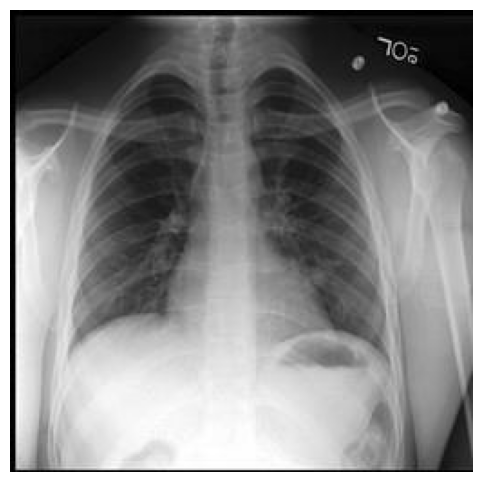

In [144]:
bg_dr = 'D:/Lab/x-ray/chexlocalize/all_result/test/'
mask_dr = 'D:/Lab/x-ray/chexlocalize/all_bg/test/'
fig, ax = plt.subplots(1, figsize = (12, 6))
for path_model in all_paths:
    
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['10', '12']:
        continue
    model.load_weights(path_model)
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_hybrid_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        patient_id = target_path[0]
        target_path = '_'.join(target_path)
        # if target_path != 'patient65127_study1_view1_frontal':
        #     continue


        # gt_mask = pickle.load(open('./segmentation_chexpert/test/' + target_path + '.pkl', "rb"))
        gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))

        if os.path.exists(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl'):
            bs = pickle.load(open(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl','rb'))
            
        else:
            
            largest_iou = 0
            for raw_record in tqdm(data_train):

                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                sid = example.features.feature['subject_id'].int64_list.value[0]
                img_id = example.features.feature['study_id'].int64_list.value[0]

                label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
                if label_test ==  1:
                    continue
                bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
                iou = calculate_iou(bs_mask, gt_mask)

                if iou > largest_iou:
                    img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                    y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                    if y_pred < 0.5:
                        largest_mask = copy.deepcopy(bs_mask)
                        largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                        largest_mask[:,:,0]= bs_mask[:,:,0]
                        largest_mask[:,:,1]= bs_mask[:,:,0]
                        largest_mask[:,:,2]= bs_mask[:,:,0]
                        largest_img_bs = copy.deepcopy(img_bs)
                        largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        bs = np.where(largest_mask > 0, largest_img_bs, 0)
                        # bs = copy.deepcopy(bs_mask)
                        # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        largest_iou = iou
            if not os.path.exists(bg_dr + patient_id):
                os.mkdir(bg_dr + patient_id)

            ax.imshow(largest_img_bs.numpy() , cmap='gray')
            ax.imshow(bs, alpha=0.5)
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/bg_hybrid_' + ep + '.png', dpi=400, bbox_inches='tight')


            ax.imshow(img.numpy() , cmap='gray')
            ax.imshow(gt_mask.numpy(), alpha=0.5)
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/img_with_hybrid.png', dpi=400, bbox_inches='tight')

            ax.imshow(largest_img_bs.numpy() , cmap='gray')
            plt.axis('off')
            plt.savefig(bg_dr + patient_id + '/bg_img_' + ep + '.png', dpi=400, bbox_inches='tight')

            if not os.path.exists(mask_dr + patient_id):
                os.mkdir(mask_dr + patient_id)
            with open(mask_dr + patient_id + '/mask_hybrid_' + ep + '.pkl','wb') as f:
                pickle.dump(bs, f)

            with open(mask_dr + patient_id + '/whole_hybrid_' + ep + '.pkl','wb') as f:
                pickle.dump(largest_img_bs.numpy(), f)

        # ig
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.numpy().astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = tf.image.rgb_to_grayscale(smooth_img2).numpy()
        # temp_img = np.mean(smooth_img2, axis=-1)
        temp_img = np.squeeze(temp_img, axis = -1)
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img.numpy()
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)
    # break
    

## IG

In [76]:
count = 0
biggest_iou = 0
dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_ig\\'
for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        bs = np.zeros((256, 256, 3))
        
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.numpy().astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img.numpy()
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

## hybrid_wo_heart_attribute each training epoch

In [42]:
attr_dict_val = dict()
for idx, each in enumerate(data_val['Path']):
    patient_id = each.split('/')[4]
    attr_dict_val[patient_id] = [data_val['Gender'][idx], data_val['Age'][idx]]

In [43]:
data_val.head()

,Path,No Finding,Pleural Effusion,Gender,Age
0,D:/Lab/CheXpert/val/patient64544/study1/view1_...,1,0,1,44
1,D:/Lab/CheXpert/val/patient64545/study1/view1_...,0,1,1,55
2,D:/Lab/CheXpert/val/patient64548/study1/view1_...,0,1,1,53
3,D:/Lab/CheXpert/val/patient64551/study1/view1_...,1,0,0,63
4,D:/Lab/CheXpert/val/patient64552/study1/view1_...,0,1,1,81


In [44]:
attr_dict_test = dict()
for idx, each in enumerate(data_test['Path']):
    patient_id = each.split('/')[4]
    attr_dict_test[patient_id] = [data_test['Gender'][idx], data_test['Age'][idx]]

In [49]:
count = 0
attr_dict = attr_dict_val
found = False
for path_model in all_paths:
    
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['08','09']:
        continue
    model.load_weights(path_model)
    
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_hybrid_wo_heart_attribute_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        patient_id = target_path[0]
        target_path = '_'.join(target_path)
        target_gender = attr_dict[patient_id][0]
        target_age = attr_dict[patient_id][1]

        if label == 1:
            img, labels, img_dim = apply_img_val_test_ig(path, label)
            y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
            if  y_pred_img < 0.5:
                continue
                
            gt_mask = pickle.load(open('./segmentation_hybrid/val_wo_heart/' + target_path + '.pkl', "rb"))
            gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
            # bs = np.zeros((256, 256, 3))
            largest_iou = 0
            found = False
            for raw_record in data_train:

                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                sid = example.features.feature['subject_id'].int64_list.value[0]
                img_id = example.features.feature['study_id'].int64_list.value[0]
                # age = example.features.feature['age'].int64_list.value[0]
                # gender = example.features.feature['gender'].int64_list.value[0]
                gender, age = dict_age[img_id]
                label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
                if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                    continue
                
                if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                    continue
                    
                found = True
                bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
                iou = calculate_iou(bs_mask, gt_mask)

                if iou > largest_iou:
                    img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                    y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                    if y_pred < 0.5:
                        largest_mask = copy.deepcopy(bs_mask)
                        largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                        largest_mask[:,:,0]= bs_mask[:,:,0]
                        largest_mask[:,:,1]= bs_mask[:,:,0]
                        largest_mask[:,:,2]= bs_mask[:,:,0]
                        largest_img_bs = copy.deepcopy(img_bs)
                        largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        bs = np.where(largest_mask > 0, largest_img_bs, 0)
                        largest_iou = iou 
            total = None
            for i in range(0, m_steps, 20):
                interpolated_img = interpolated_image(baseline=bs, image=img,
                        alphas=alphas[i : i + 20])

                path_gradient = compute_gradients(interpolated_img,  0)
                mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

                if total == None:
                    total = mean
                else:
                    total = tf.concat([total, mean], axis = 0)
            total = tf.math.reduce_mean(total, axis = 0)
            cast_img = img.numpy().astype(np.float32)
            bs = bs.astype(np.float32)
            ig = (cast_img - bs) * total.numpy()
            result = abs(ig)

            result = (result - result.min()) / (result.max() - result.min())
            q1, q2, q3 = np.percentile(result, [25, 50, 75])
            iqr = q3 - q1
            maximum = q3 + 1.5 * iqr
            temp2 = copy.deepcopy(result)
            temp2[result < maximum] = 0
            blurred3 = cv2.medianBlur(temp2, 5)
            blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
            norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
            smooth_img2 = copy.deepcopy(blurred3)
            temp_img = np.mean(smooth_img2, axis=-1)
            json_dict = {}
            json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
            json_dict['prob'] = y_pred_img
            json_dict['task'] = 'Pleural Effusion'
            json_dict['gt'] = 1
            json_dict['cxr_img'] = img.numpy()
            json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

            with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
                pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [48]:
count = 0
attr_dict = attr_dict_test
found = False
for path_model in all_paths:
    
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['08','09']:
        continue
    model.load_weights(path_model)
    
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_hybrid_wo_heart_attribute_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        patient_id = target_path[0]
        target_path = '_'.join(target_path)
        target_gender = attr_dict[patient_id][0]
        target_age = attr_dict[patient_id][1]

        if label == 1:
            img, labels, img_dim = apply_img_val_test_ig(path, label)
            y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
            if  y_pred_img < 0.5:
                continue
                
            gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
            gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
            # bs = np.zeros((256, 256, 3))
            largest_iou = 0
            found = False
            for raw_record in data_train:

                example = tf.train.Example()
                example.ParseFromString(raw_record.numpy())
                sid = example.features.feature['subject_id'].int64_list.value[0]
                img_id = example.features.feature['study_id'].int64_list.value[0]
                # age = example.features.feature['age'].int64_list.value[0]
                # gender = example.features.feature['gender'].int64_list.value[0]
                gender, age = dict_age[img_id]
                label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
                if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                    continue
                
                if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                    continue
                    
                found = True
                bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
                iou = calculate_iou(bs_mask, gt_mask)

                if iou > largest_iou:
                    img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                    y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                    if y_pred < 0.5:
                        largest_mask = copy.deepcopy(bs_mask)
                        largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                        largest_mask[:,:,0]= bs_mask[:,:,0]
                        largest_mask[:,:,1]= bs_mask[:,:,0]
                        largest_mask[:,:,2]= bs_mask[:,:,0]
                        largest_img_bs = copy.deepcopy(img_bs)
                        largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        bs = np.where(largest_mask > 0, largest_img_bs, 0)
                        # bs = copy.deepcopy(bs_mask)
                        # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                        largest_iou = iou 
            total = None
            for i in range(0, m_steps, 20):
                interpolated_img = interpolated_image(baseline=bs, image=img,
                        alphas=alphas[i : i + 20])

                path_gradient = compute_gradients(interpolated_img,  0)
                mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

                if total == None:
                    total = mean
                else:
                    total = tf.concat([total, mean], axis = 0)
            total = tf.math.reduce_mean(total, axis = 0)
            cast_img = img.numpy().astype(np.float32)
            bs = bs.astype(np.float32)
            ig = (cast_img - bs) * total.numpy()
            result = abs(ig)

            result = (result - result.min()) / (result.max() - result.min())
            q1, q2, q3 = np.percentile(result, [25, 50, 75])
            iqr = q3 - q1
            maximum = q3 + 1.5 * iqr
            temp2 = copy.deepcopy(result)
            temp2[result < maximum] = 0
            blurred3 = cv2.medianBlur(temp2, 5)
            blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
            norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
            smooth_img2 = copy.deepcopy(blurred3)
            temp_img = np.mean(smooth_img2, axis=-1)
            json_dict = {}
            json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
            json_dict['prob'] = y_pred_img
            json_dict['task'] = 'Pleural Effusion'
            json_dict['gt'] = 1
            json_dict['cxr_img'] = img.numpy()
            json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

            with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
                pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## hybrid_wo_heart_attribute_noise

In [51]:
count = 0
attr_dict = attr_dict_val
found = False

model.load_weights('./model/noise_baseline.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_hybrid_wo_heart_attribute_noise\\'
if not os.path.exists(dr):
    os.mkdir(dr)

for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict[patient_id][0]
    target_age = attr_dict[patient_id][1]

    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if  y_pred_img < 0.5:
            continue

        gt_mask = pickle.load(open('./segmentation_hybrid/val_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        # bs = np.zeros((256, 256, 3))
        largest_iou = 0
        found = False
        for raw_record in data_train:

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            # age = example.features.feature['age'].int64_list.value[0]
            # gender = example.features.feature['gender'].int64_list.value[0]
            gender, age = dict_age[img_id]
            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                continue

            if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                continue

            found = True
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    # bs = copy.deepcopy(bs_mask)
                    # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    largest_iou = iou 
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

In [52]:
count = 0
attr_dict = attr_dict_test
found = False

model.load_weights('./model/noise_baseline.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_hybrid_wo_heart_attribute_noise\\'
if not os.path.exists(dr):
    os.mkdir(dr)

for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict[patient_id][0]
    target_age = attr_dict[patient_id][1]

    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if  y_pred_img < 0.5:
            continue

        gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        # bs = np.zeros((256, 256, 3))
        largest_iou = 0
        found = False
        for raw_record in data_train:

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            # age = example.features.feature['age'].int64_list.value[0]
            # gender = example.features.feature['gender'].int64_list.value[0]
            gender, age = dict_age[img_id]
            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                continue

            if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                continue

            found = True
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    # bs = copy.deepcopy(bs_mask)
                    # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    largest_iou = iou 
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

In [53]:
count = 0
attr_dict = attr_dict_val
found = False

model.load_weights('./model/noise_baseline_v2.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_hybrid_wo_heart_attribute_noise_v2\\'
if not os.path.exists(dr):
    os.mkdir(dr)

for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict[patient_id][0]
    target_age = attr_dict[patient_id][1]

    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if  y_pred_img < 0.5:
            continue

        gt_mask = pickle.load(open('./segmentation_hybrid/val_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        # bs = np.zeros((256, 256, 3))
        largest_iou = 0
        found = False
        for raw_record in data_train:

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            # age = example.features.feature['age'].int64_list.value[0]
            # gender = example.features.feature['gender'].int64_list.value[0]
            gender, age = dict_age[img_id]
            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                continue

            if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                continue

            found = True
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    # bs = copy.deepcopy(bs_mask)
                    # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    largest_iou = iou 
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

In [54]:
count = 0
attr_dict = attr_dict_test
found = False

model.load_weights('./model/noise_baseline_v2.h5')

dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_hybrid_wo_heart_attribute_noise_v2\\'
if not os.path.exists(dr):
    os.mkdir(dr)

for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    target_gender = attr_dict[patient_id][0]
    target_age = attr_dict[patient_id][1]

    if label == 1:
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if  y_pred_img < 0.5:
            continue

        gt_mask = pickle.load(open('./segmentation_hybrid/test_wo_heart/' + target_path + '.pkl', "rb"))
        gt_mask = tf.image.resize(tf.expand_dims(gt_mask, axis=-1), (IMAGE_WIDTH, IMAGE_HEIGHT))
        # bs = np.zeros((256, 256, 3))
        largest_iou = 0
        found = False
        for raw_record in data_train:

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            sid = example.features.feature['subject_id'].int64_list.value[0]
            img_id = example.features.feature['study_id'].int64_list.value[0]
            # age = example.features.feature['age'].int64_list.value[0]
            # gender = example.features.feature['gender'].int64_list.value[0]
            gender, age = dict_age[img_id]
            label_test = 0 if example.features.feature['No Finding'].float_list.value[0] == 1 else 1
            if label_test ==  1 or gender != target_gender or age < target_age - 5 or age > target_age + 5:
                continue

            if not (int(target_age) -5 <= int(age) <= int(target_age) + 5):
                continue

            found = True
            bs_mask = tf.expand_dims(pickle.load(open('./segmentation_hybrid/train_wo_heart/' + str(img_id) + '.pkl', "rb")), axis=-1)
            iou = calculate_iou(bs_mask, gt_mask)

            if iou > largest_iou:
                img_bs = apply(example.features.feature['jpg_bytes'].bytes_list.value[0])
                y_pred = model.predict(tf.expand_dims(img_bs, axis=0))[0][0]
                if y_pred < 0.5:
                    largest_mask = copy.deepcopy(bs_mask)
                    largest_mask = np.zeros((bs_mask.numpy().shape[0], bs_mask.numpy().shape[1], 3))
                    largest_mask[:,:,0]= bs_mask[:,:,0]
                    largest_mask[:,:,1]= bs_mask[:,:,0]
                    largest_mask[:,:,2]= bs_mask[:,:,0]
                    largest_img_bs = copy.deepcopy(img_bs)
                    largest_mask = tf.image.resize(largest_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    bs = np.where(largest_mask > 0, largest_img_bs, 0)
                    # bs = copy.deepcopy(bs_mask)
                    # bs = tf.image.resize(bs_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
                    largest_iou = iou 
        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(baseline=bs, image=img,
                    alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  0)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        cast_img = img.astype(np.float32)
        bs = bs.astype(np.float32)
        ig = (cast_img - bs) * total.numpy()
        result = abs(ig)

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 1.5 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2, 5)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        norm_img = (cast_img - cast_img.min()) / (cast_img.max() - cast_img.min())
        smooth_img2 = copy.deepcopy(blurred3)
        temp_img = np.mean(smooth_img2, axis=-1)
        json_dict = {}
        json_dict['map'] = temp_img[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

# Other saliency method

In [72]:
def get_last_conv_model(model):
    input_layer = model.get_layer(model.layers[0].name)
    upsampling = model.get_layer(model.layers[1].name)
    upsampling1 = model.get_layer(model.layers[2].name)
    upsampling2 = model.get_layer(model.layers[3].name)
    denset121 = model.get_layer(model.layers[4].name)

    last_conv_layer_model = tf.keras.Sequential()
    last_conv_layer_model.add(tf.keras.Model(model.inputs, denset121.layers[-4].output))
    
    classifier_input = tf.keras.Input(shape=denset121.layers[-3].output.shape[1:])
    x = classifier_input
    for layer in denset121.layers[-3:]:
        x = denset121.get_layer(layer.name)(x)
    x = model.get_layer(model.layers[-1].name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)   
    
    return last_conv_layer_model, classifier_model
    # return last_conv_layer_model

In [73]:
last, classifier = get_last_conv_model(model)
last.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 8, 8, 1024)        7033408   
Total params: 7,033,408
Trainable params: 6,951,808
Non-trainable params: 81,600
_________________________________________________________________


In [74]:
classifier.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 1024)]      0         
_________________________________________________________________
bn (BatchNormalization)      (None, 8, 8, 1024)        4096      
_________________________________________________________________
relu (Activation)            (None, 8, 8, 1024)        0         
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 5,121
Trainable params: 3,073
Non-trainable params: 2,048
_________________________________________________________________


In [75]:
def make_gradcam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class=None):

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        
        if (target_class is not None):
            top_pred_index = tf.constant(target_class)
        else:
            top_pred_index = tf.argmax(preds[0])
        
        top_class_channel = preds[:, top_pred_index]
                
        grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

def make_gradcam_plus_heatmap(img_array, last_conv_layer_model, classifier_model, target_class=None):

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape:
                last_conv_layer_output = last_conv_layer_model(img_array)
                tape.watch(last_conv_layer_output)
                tape2.watch(last_conv_layer_output)
                tape1.watch(last_conv_layer_output)
                # Compute class predictions
                preds = classifier_model(last_conv_layer_output)

                if (target_class is not None):
                    top_pred_index = tf.constant(target_class)
                else:
                    top_pred_index = tf.argmax(preds[0])

                top_class_channel = preds[:, top_pred_index]

                grads = tape.gradient(top_class_channel, last_conv_layer_output)
            grads2 = tape2.gradient(grads, last_conv_layer_output)
        grads3 = tape1.gradient(grads2, last_conv_layer_output)
    global_sum = np.sum(last_conv_layer_output, axis=(0, 1, 2))

    alpha_num = grads2[0]
    alpha_denom = grads2[0]*2.0 + grads3[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alpha_normalization_constant = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, 1e-10)
    alphas /= alpha_normalization_constant

    weights = np.maximum(grads[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*last_conv_layer_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def make_eigen_cam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class=None):
    last_conv_layer_output = last_conv_layer_model(img_array)
    preds = classifier_model(last_conv_layer_output)

    U, S, VT = np.linalg.svd(last_conv_layer_output, full_matrices=True)
    projection = last_conv_layer_output @ VT[:,0,:]


    heatmap = np.maximum(tf.reduce_mean(projection[0], axis=-1), 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def make_eigen_gradcam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class=None):

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)

        if (target_class is not None):
            top_pred_index = tf.constant(target_class)
        else:
            top_pred_index = tf.argmax(preds[0])

        top_class_channel = preds[:, top_pred_index]

        grads = tape.gradient(top_class_channel, last_conv_layer_output)
    activations = grads * last_conv_layer_output
    U, S, VT = np.linalg.svd(activations, full_matrices=True)
    projection = activations @ VT[:,0,:]


    heatmap = np.maximum(tf.reduce_mean(projection[0], axis=-1), 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def show_heatmap(img_array, last_conv_layer_model, classifier_model, eigen = True, plus = True, target_class=None):
    if eigen:
        if not plus:
            heatmap = make_eigen_cam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class)
        else:
            heatmap = make_eigen_gradcam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class)
    else:
        if not plus:
            heatmap = make_gradcam_heatmap(img_array, last_conv_layer_model, classifier_model, target_class)
        else:
            heatmap = make_gradcam_plus_heatmap(img_array, last_conv_layer_model, classifier_model, target_class)
        
    return heatmap

In [263]:
count = 0
for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
    target_path = path.split('/')[4:]
    target_path[-1] = target_path[-1].split('.')[0]
    patient_id = target_path[0]
    target_path = '_'.join(target_path)
    
    if patient_id != 'patient64763':
        continue
    if label == 0:
        continue
    img, labels, img_dim = apply_img_val_test_ig(path, label)
    img, pred_mask = fn2(img.numpy())
    json_dict = {}

    y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
    if y_pred_img < 0.5:
        continue

    heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier)
    capi=resize(heatmap,(256,256))
    if count == 0:
        final_res = capi[np.newaxis, :]
        final_img = img[np.newaxis, :]
    else: 
        final_res = np.concatenate((capi[np.newaxis, :], final_res), axis = 0)
        final_img = np.concatenate((img[np.newaxis, :], final_img), axis = 0)
    count += 1
    break

res = np.mean(final_res, axis=0)
img_avg = np.mean(final_img, axis=0)

0it [00:00, ?it/s]

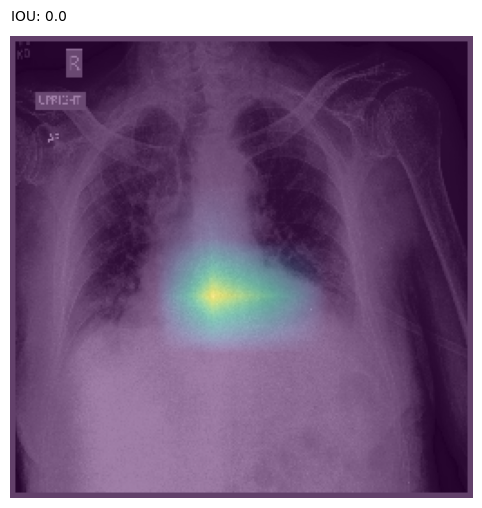

In [265]:
fig, ax = plt.subplots(1, figsize = (12, 6))
res_mask = np.where(res <= 0, 0, 1)
iou = calculate_iou(res_mask, pred_mask)
ax.imshow(img_avg.astype(np.uint8), cmap='gray')
ax.imshow(res, alpha=0.5)
ax.text(0, 0, 'IOU: {}\n'.format(iou))
plt.axis('off')
plt.savefig('./sbj_patient64763_noise_v1_eigen_gradcam.png', dpi=400, bbox_inches='tight')

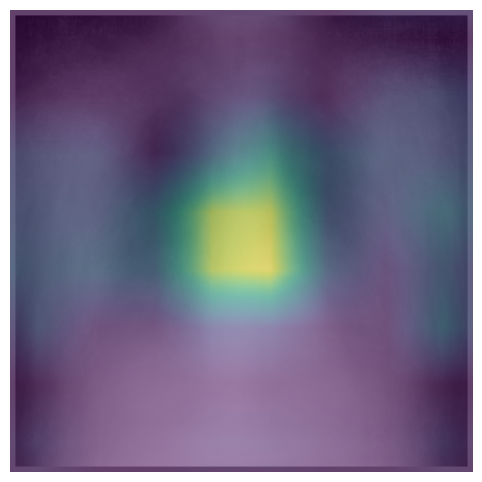

In [145]:
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.imshow(img_avg.astype(np.uint8), cmap='gray')
ax.imshow(res, alpha=0.5)
plt.axis('off')
plt.savefig('./result_figure/avg_noise_eigen_gradcam.png', dpi=400, bbox_inches='tight')

In [46]:
for path_model in all_paths:
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['10','12']:
        continue
    model.load_weights(path_model)
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_gradcam_plus_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
    i = 0
    for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue

        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier, eigen = False, plus = False)
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img.numpy()
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [47]:
for path_model in all_paths:
    ep = str(path_model).split('-')[0][-2:]
    if ep not in ['10', '12']:
        continue
    model.load_weights(path_model)
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_gradcam_plus_'+ ep +'\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
    for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue

        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier)
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img.numpy()
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

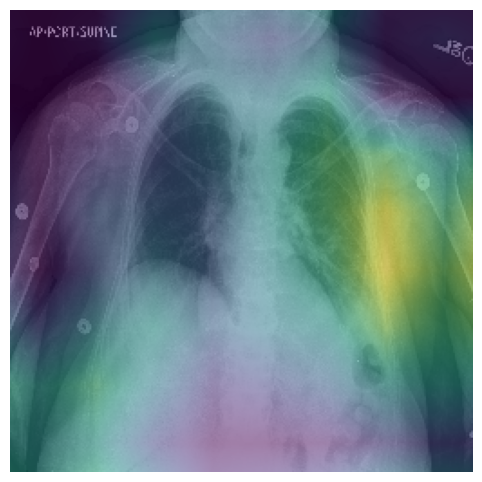

In [59]:
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.imshow(img, cmap='gray')
ax.imshow(capi, alpha=0.5)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

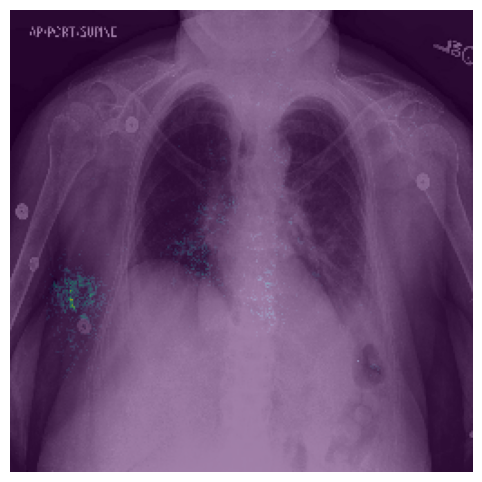

In [67]:
json_dict = pickle.load(open("D:\\Lab\\x-ray\\chexlocalize\\result\\" + target_path + "_Pleural Effusion_map.pkl", "rb"))
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.imshow(json_dict['cxr_img'], cmap='gray')
ax.imshow(json_dict['map'][0][0], alpha=0.5)
plt.axis('off')

## Noise other saliency methods

In [35]:
model

'gradcam'

In [54]:
all_model = ['gradcam', 'gradcam_plus','eigen', 'eigen_gradcam']
eigen_bool = [False, False, True, True]
gradcam_bool = [False, True, False, True]
model.load_weights('./model/noise_baseline.h5')

for idx, cur_model in enumerate(all_model):
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_' + cur_model +'_noise\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    i = 0
    for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        
        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier, eigen = eigen_bool[idx], plus = gradcam_bool[idx])
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)
            
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_' + cur_model +'_noise\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    i = 0
    for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn2(img.numpy())
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        
        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier, eigen = eigen_bool[idx], plus = gradcam_bool[idx])
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [76]:
all_model = ['gradcam', 'gradcam_plus','eigen', 'eigen_gradcam']
eigen_bool = [False, False, True, True]
gradcam_bool = [False, True, False, True]
# model.load_weights('./model/noise_baseline_v2.h5')

for idx, cur_model in enumerate(all_model):
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_val_' + cur_model +'_noise_v2\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    i = 0
    for path, label in tqdm(zip(np.array(img_path_val), target_label_val)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        
        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier, eigen = eigen_bool[idx], plus = gradcam_bool[idx])
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)
            
    dr = 'D:\\Lab\\x-ray\\chexlocalize\\result_test_' + cur_model +'_noise_v2\\'
    if not os.path.exists(dr):
        os.mkdir(dr)
        
    i = 0
    for path, label in tqdm(zip(np.array(img_path_test), target_label_test)):
        if label == 0:
            continue
        img, labels, img_dim = apply_img_val_test_ig(path, label)
        img, pred_mask = fn3(img.numpy())
        json_dict = {}

        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img < 0.5:
            continue
        
        heatmap = show_heatmap(tf.expand_dims(img, axis=0), last, classifier, eigen = eigen_bool[idx], plus = gradcam_bool[idx])
        capi=resize(heatmap,(256,256))
        json_dict['map'] = capi[np.newaxis, np.newaxis, :,:]
        json_dict['prob'] = y_pred_img
        json_dict['task'] = 'Pleural Effusion'
        json_dict['gt'] = 1
        json_dict['cxr_img'] = img
        json_dict['cxr_dims'] = (img_dim[1], img_dim[0])

        target_path = path.split('/')[4:]
        target_path[-1] = target_path[-1].split('.')[0]
        target_path = '_'.join(target_path)
        with open(dr + target_path + '_Pleural Effusion_map.pkl','wb') as f:
            pickle.dump(json_dict, f)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]